# Combinatorial Optimization (CO) (3 appliances combination)
- This notebook is written to use the **CO algorithm** to train a model using our lab data
- This allows us to use only the **power dataframe in MultiIndex format** instead of the MeterGroup format from NILMTK to use the algorithm's functions

**Training dataset**
- Model is trained using kettle+vacuum+water_heater 10 mins data
    - Expected to be able to detect 3 appliance classification
    
**Training module steps:**
1. Subsampling process
2. K-Means clustering

**Testing dataset:**
1. Disaggregation will be using kettle+vacuum+water_heater 4 mins data
    - Expected that it will struggle to classify these 3 appliances properly
    
**Disaggregation module steps:**
1. Import trained model
2. Combination of states
3. Finding nearest
4. Predicted vs ground truth comparison
5. Evaluation

Note: The headings represents the function names found in NILMTK algorithm code

In [1]:
# Importing libraries for working with DataFrames and visualizations
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

import pickle
import warnings

# For evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Importing the following for working with NILM dataset
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.utils import print_dict, find_nearest
from nilmtk.api import API

# CO functions
#from nilmtk.disaggregate.combinatorial_optimisation import CO
from nilmtk.legacy.disaggregate import CombinatorialOptimisation
from nilmtk.feature_detectors import cluster
from nilmtk.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
# Global variables #
# For API functions
appliances = ["kettle", "vacuum", "water heater"]
train_submeters = []
train_mains = []
test_submeters = []
test_mains = pd.DataFrame()
gt_overall = {}
pred_overall = {}
classifiers=[]
errors = []
errors_keys = []

# For CO functions
model = []
MODEL_NAME = 'CO'
state_combinations = None
MIN_CHUNK_LENGTH = 100

power = 'active'

metrics = ['mae', 'rmse', 'f1score']
sample_period = 1
site_only = False

In [3]:
#1 dimensional combinatorial optimisation NILM algorithm
obj_co = CombinatorialOptimisation()

# Dataset preparation - Training
Changing lab power data into df that can feed into NILMTK function

- Data : kettle + vacuum + water heater: has main, kettle, vacuum, water heater load data
- Frequency: 1Hz
- Duration : 10mins 21s
- Pattern: Multiple on/off states

In [4]:
def get_multiIndex(appliance_df, columns):
    df_app = pd.DataFrame(appliance_df['Active (W)'])
    df_app.columns = columns
    df_app.columns.names = ['physical_quantity', 'type']
    df_app.index = pd.to_datetime(df_app.index)
    df_app.index.name = None
    return df_app

In [5]:
# Load main
main_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/train_data/main.csv", index_col=0)

# Load submeters
kettle_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/train_data/kettle.csv", index_col=0)
vacuum_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/train_data/vacuum.csv", index_col=0)
wh_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/train_data/water_heater.csv", index_col=0)

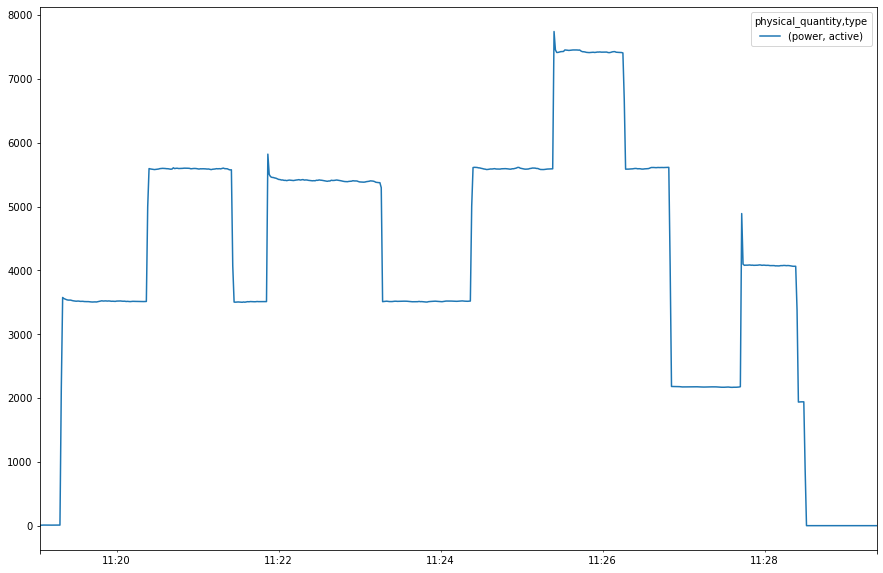

In [6]:
# Convert lab data to multiIndex df
# set column
columns = pd.MultiIndex.from_tuples([('power','active')])

# main
df_main = get_multiIndex(main_df, columns)
# Kettle
df_ke = get_multiIndex(kettle_df, columns)
# Vacuum
df_vac = get_multiIndex(vacuum_df, columns)
# Water Heater
df_wh = get_multiIndex(wh_df, columns)

df_main
df_main.plot()

In [7]:
# Append appliances into one list
appliance_readings = []
appliance_readings.append(df_ke)
appliance_readings.append(df_vac)
appliance_readings.append(df_wh)

appliance_readings

[physical_quantity    power
 type                active
 2022-11-22 11:19:03    0.0
 2022-11-22 11:19:04    0.0
 2022-11-22 11:19:05    0.0
 2022-11-22 11:19:06    0.0
 2022-11-22 11:19:07    0.0
 ...                    ...
 2022-11-22 11:29:19    0.0
 2022-11-22 11:29:20    0.0
 2022-11-22 11:29:21    0.0
 2022-11-22 11:29:22    0.0
 2022-11-22 11:29:23    0.0
 
 [621 rows x 1 columns],
 physical_quantity    power
 type                active
 2022-11-22 11:19:03    0.0
 2022-11-22 11:19:04    0.0
 2022-11-22 11:19:05    0.0
 2022-11-22 11:19:06    0.0
 2022-11-22 11:19:07    0.0
 ...                    ...
 2022-11-22 11:29:19    0.0
 2022-11-22 11:29:20    0.0
 2022-11-22 11:29:21    0.0
 2022-11-22 11:29:22    0.0
 2022-11-22 11:29:23    0.0
 
 [621 rows x 1 columns],
 physical_quantity    power
 type                active
 2022-11-22 11:19:03    0.0
 2022-11-22 11:19:04    0.0
 2022-11-22 11:19:05    0.0
 2022-11-22 11:19:06    0.0
 2022-11-22 11:19:07    0.0
 ...                  

In [8]:
# Aggregated load is already in mains, no need to artificial aggregate
train_df = df_main
train_submeters = [[] for i in range(len(appliances))]
train_mains = []

train_mains.append(train_df)
for i,name in enumerate(appliances):
    train_submeters[i].append(appliance_readings[i])

appliance_readings = []
for i,appliance_name in enumerate(appliances):
    appliance_readings.append((appliance_name, train_submeters[i]))

train_submeters = appliance_readings 

# Training
Extracting code from NILMTK API and CO to use for lab data

## Partial Fit
- Inside the CO **cluster function**:
    1. Data is **subsampled** by taking random 2000 samples from train data
    2. The subsampled data is then used for **K-Means clustering**

In [9]:
def partial_fit(
    train_main,
    train_appliances,
    do_preprocessing=True,
    **load_kwargs):

    train_main = pd.concat(train_main, axis=0)
    train_app_tmp = []

    for app_name, df_list in train_appliances:
        df_list = pd.concat(df_list, axis=0)
        train_app_tmp.append((app_name, df_list))

    train_appliances = train_app_tmp

    print("...............CO partial_fit running.............")
    num_on_states = None
    if len(train_appliances) > 12:
        max_num_clusters = 2
    else:
        max_num_clusters = 3
    appliance_in_model = [d['appliance_name'] for d in model]

    for appliance, readings in train_appliances:
        #print(appliance," ",readings)
        if appliance in appliance_in_model:
            #     raise RuntimeError(
            #     "Appliance {} is already in model!"
            #     "  Can't train twice on the same meter!",appliance)
            print("Trained on " + appliance + " before.")

        else:
            states = cluster(readings, max_num_clusters, num_on_states)
            model.append({
                'states': states,
                'appliance_name': appliance})

In [10]:
start_time = time.time()
partial_fit(train_mains,train_submeters)
print("---Runtime: %s seconds ---" % (time.time() - start_time))

...............CO partial_fit running.............
---Runtime: 0.11024951934814453 seconds ---


In [11]:
# centroid/states saved to model dict
obj_co.model = model
obj_co.model

[{'states': array([   0, 1271, 2137], dtype=int32),
  'appliance_name': 'kettle'},
 {'states': array([   0, 1009, 1935], dtype=int32),
  'appliance_name': 'vacuum'},
 {'states': array([   0, 2019, 3456], dtype=int32),
  'appliance_name': 'water heater'}]

# Dataset preparation - Testing
Changing lab power data into df that can feed into NILMTK 

- Data     : kettle + vacuum + water heater: has main, kettle, vacuum, water heater load data
- Frequency: 1Hz
- Duration : 4mins 47s
- Data type: active power only

In [12]:
# Load main
main_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/test_data/main.csv", index_col=0)

# Load submeters
kettle_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/test_data/kettle.csv", index_col=0)
vacuum_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/test_data/vacuum.csv", index_col=0)
wh_df=pd.read_csv("../Lab_Dataset/3combi_kettle+vacuum+wheater/test_data/water_heater.csv", index_col=0)

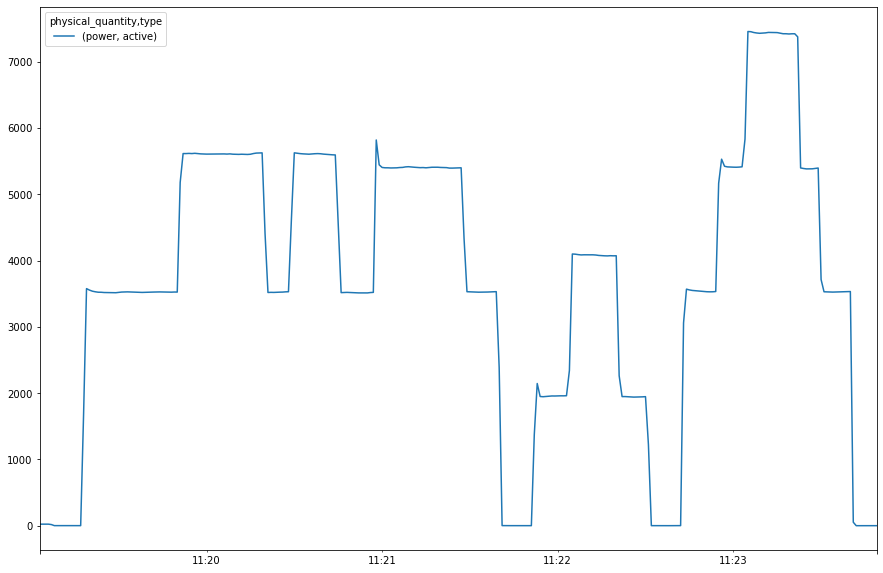

In [13]:
# Convert lab data to multiIndex df
# set column
columns = pd.MultiIndex.from_tuples([('power','active')])

# main
df_main = get_multiIndex(main_df, columns)
# Kettle
df_ke = get_multiIndex(kettle_df, columns)
# Vacuum
df_vac = get_multiIndex(vacuum_df, columns)
# Water Heater
df_wh = get_multiIndex(wh_df, columns)

df_main
df_main.plot()

In [14]:
# Append appliances into one list
appliance_readings = []
appliance_readings.append(df_ke)
appliance_readings.append(df_vac)
appliance_readings.append(df_wh)

# Aggregated load is already in mains, no need to artificial aggregate
test_df = df_main

test_submeters = [[] for i in range(len(appliances))]
test_mains = []

test_mains.append(test_df)
for i,name in enumerate(appliances):
    test_submeters[i].append(appliance_readings[i])

appliance_readings = []
for i,appliance_name in enumerate(appliances):
    appliance_readings.append((appliance_name, test_submeters[i]))

test_submeters = appliance_readings 

# Predict

## Disaggregate module

- Inside the disaggregate_chunk function, there is predict function
- Inside the **predict function**: 
    1. Set **state combination**
        - The states/centroids of all appliances are combined in an array by cartesian product
    2. **Find Nearest**
        - Find the nearest values between the combined states (observed) with the test mains (predicted)
        - Using the indices of state combination to figure out the combination of appliance

### Predict function
- The overall predict function to run the 2 main processes for disaggregation

In [15]:
def predict(test_mains, test_submeters):
    print ("Generating predictions for :",MODEL_NAME)        
    """
    Generates predictions on the test dataset using the specified classifier.
    """
        
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.   
           
    pred_list = disaggregate_chunk(test_mains)

    # It might not have time stamps sometimes due to neural nets
    # It has the readings for all the appliances

    concat_pred_df = pd.concat(pred_list,axis=0)

    gt = {}
    for meter,data in test_submeters:
        concatenated_df_app = pd.concat(data,axis=1)
        index = concatenated_df_app.index
        gt[meter] = pd.Series(concatenated_df_app.values.flatten(),index=index)

    gt_overall = pd.DataFrame(gt, dtype='float32')
    pred = {}

    if site_only ==True:
        for app_name in concat_pred_df.columns:
            app_series_values = concat_pred_df[app_name].values.flatten()
            pred[app_name] = pd.Series(app_series_values)
        pred_overall = pd.DataFrame(pred,dtype='float32')
        pred_overall.plot(label="Pred")
        plt.title('Disaggregated Data')
        plt.legend()

    else:
        for app_name in concat_pred_df.columns:
            app_series_values = concat_pred_df[app_name].values.flatten()
            # Neural nets do extra padding sometimes, to fit, so get rid of extra predictions
            app_series_values = app_series_values[:len(gt_overall[app_name])]
            pred[app_name] = pd.Series(app_series_values, index = gt_overall.index)
        pred_overall = pd.DataFrame(pred,dtype='float32')
        
    return gt_overall, pred_overall

### Disaggregate chunk function
- Containing main functions (set **state combi** func & **find nearest** process) to disaggregate

In [16]:
def disaggregate_chunk(mains):
    """In-memory disaggregation.

    Parameters
    ----------
    mains : pd.Series


    Returns
    -------
    appliance_powers : pd.DataFrame where each column represents a
        disaggregated appliance.  Column names are the integer index
        into `self.model` for the appliance in question.
    """
    '''if not self.model:
        raise RuntimeError(
            "The model needs to be instantiated before"
            " calling `disaggregate`.  The model"
            " can be instantiated by running `train`.")'''

    print("...............CO disaggregate_chunk running.............")

    # sklearn produces lots of DepreciationWarnings with PyTables
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning)


    # Call set state combination
    state_combinations = None
    combinations = _set_state_combinations_if_necessary(state_combinations)
    
    print("\nCombinations: \n", combinations)
    
    # Sum the combination of states
    summed_power_of_each_combination = np.sum(combinations, axis=1)
    print("\nSum of each combination: \n", summed_power_of_each_combination)
    # value is the total power demand for each combination of states.

    # Start disaggregation

    test_prediction_list = []

    for test_df in mains:

        appliance_powers_dict = {}
        
        # Find nearest
        indices_of_state_combinations, residual_power = find_nearest(
            summed_power_of_each_combination, test_df.values)

        for i, model in enumerate(obj_co.model):
            print("\nEstimating power demand for '{}'"
                    .format(model['appliance_name']))
            predicted_power = combinations[
                indices_of_state_combinations, i].flatten()
            print("Predicted_power: \n", predicted_power)
            column = pd.Series(
                predicted_power, index=test_df.index, name=i)
            appliance_powers_dict[obj_co.model[i]['appliance_name']] = column

        appliance_powers = pd.DataFrame(
            appliance_powers_dict, dtype='float32')
        test_prediction_list.append(appliance_powers)

    return test_prediction_list

### Set State Combination function

In [17]:
def _set_state_combinations_if_necessary(state_combinations):
    """Get centroids"""
    # If we import sklearn at the top of the file then auto doc fails.
    if (state_combinations is None or
            state_combinations.shape[1] != len(model)):
        from sklearn.utils.extmath import cartesian
        centroids = [model['states'] for model in model]
        print("centroids ...",centroids)
        state_combinations = cartesian(centroids)
    return state_combinations

## Generate prediction/disaggregation

In [18]:
start_time = time.time()
# Call predict function
gt_overall,pred_overall=predict(test_mains,test_submeters)
print("---Runtime: %s seconds ---" % (time.time() - start_time))

Generating predictions for : CO
...............CO disaggregate_chunk running.............
centroids ... [array([   0, 1271, 2137], dtype=int32), array([   0, 1009, 1935], dtype=int32), array([   0, 2019, 3456], dtype=int32)]

Combinations: 
 [[   0    0    0]
 [   0    0 2019]
 [   0    0 3456]
 [   0 1009    0]
 [   0 1009 2019]
 [   0 1009 3456]
 [   0 1935    0]
 [   0 1935 2019]
 [   0 1935 3456]
 [1271    0    0]
 [1271    0 2019]
 [1271    0 3456]
 [1271 1009    0]
 [1271 1009 2019]
 [1271 1009 3456]
 [1271 1935    0]
 [1271 1935 2019]
 [1271 1935 3456]
 [2137    0    0]
 [2137    0 2019]
 [2137    0 3456]
 [2137 1009    0]
 [2137 1009 2019]
 [2137 1009 3456]
 [2137 1935    0]
 [2137 1935 2019]
 [2137 1935 3456]]

Sum of each combination: 
 [   0 2019 3456 1009 3028 4465 1935 3954 5391 1271 3290 4727 2280 4299
 5736 3206 5225 6662 2137 4156 5593 3146 5165 6602 4072 6091 7528]

Estimating power demand for 'kettle'
Predicted_power: 
 [   0    0    0    0    0    0    0    0    0   

In [19]:
pred_overall

,kettle,vacuum,water heater
2022-11-22 11:19:03,0.0,0.0,0.0
2022-11-22 11:19:04,0.0,0.0,0.0
2022-11-22 11:19:05,0.0,0.0,0.0
2022-11-22 11:19:06,0.0,0.0,0.0
2022-11-22 11:19:07,0.0,0.0,0.0
...,...,...,...
2022-11-22 11:23:45,0.0,0.0,0.0
2022-11-22 11:23:46,0.0,0.0,0.0
2022-11-22 11:23:47,0.0,0.0,0.0
2022-11-22 11:23:48,0.0,0.0,0.0


# Data visualization
To compare the ground truth vs predicted appliance loads

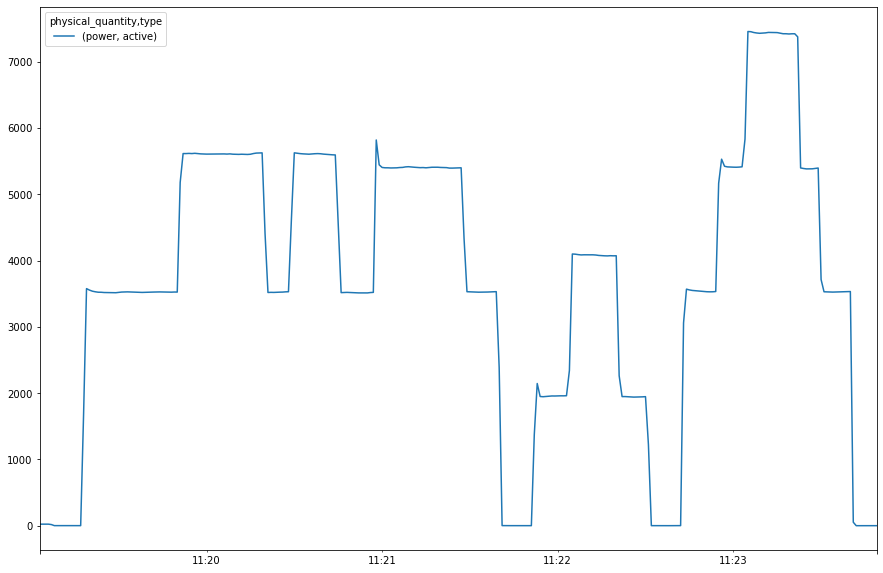

In [20]:
df_main.plot()

In [21]:
# Get steady state points to plot
x=gt_overall.index
ke_val = gt_overall['kettle'].values
vac_val = gt_overall['vacuum'].values
wh_val = gt_overall['water heater'].values

# Kettle steady state point
ke_ss = gt_overall.iloc[90]['kettle']
x_ke = np.where(ke_val==ke_ss)
x_ke = x[x_ke]

# Vacuum steady state point
vac_ss = gt_overall.iloc[180]['vacuum']
x_vac = np.where(vac_val==vac_ss)
x_vac = x[x_vac]

# Water heater steady state point
wh_ss = gt_overall.iloc[50]['water heater']
x_wh = np.where(wh_val==wh_ss)
x_wh = x[x_wh]

Text(5, 10, '3448.61')

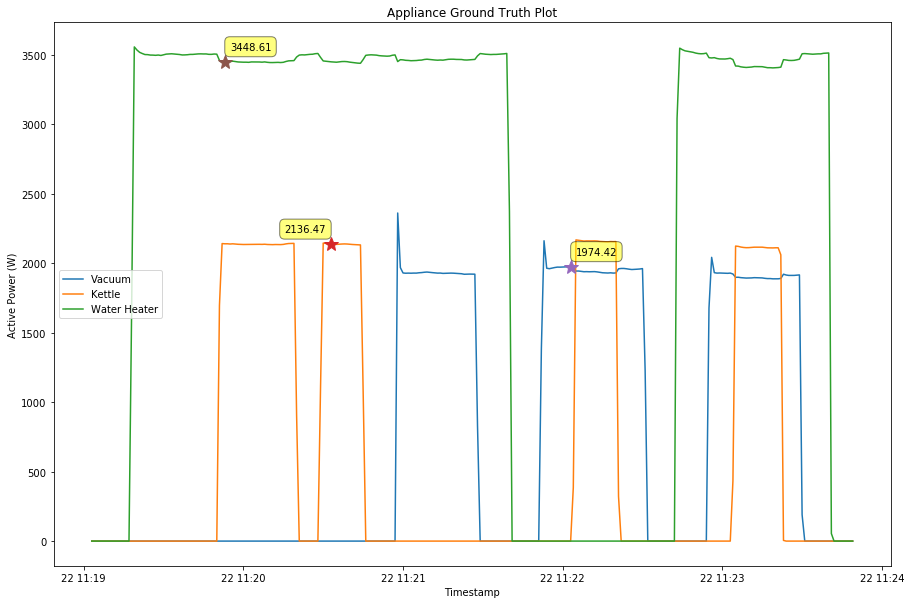

In [22]:
# Plot GT 
gt_vac = plt.plot(gt_overall.index, gt_overall['vacuum'], label = 'Vacuum')
gt_ke = plt.plot(gt_overall.index, gt_overall['kettle'], label = 'Kettle')
gt_wh = plt.plot(gt_overall.index, gt_overall['water heater'], label = 'Water Heater')
point1 = plt.plot(x_ke[0],ke_ss,marker="*",markersize=15)
point2 = plt.plot(x_vac[0],vac_ss,marker="*",markersize=15)
point3 = plt.plot(x_wh[0],wh_ss,marker="*",markersize=15)

plt.title("Appliance Ground Truth Plot")
plt.legend()
plt.ylabel("Active Power (W)")
plt.xlabel("Timestamp")

# annotate kettle point
plt.annotate(
        ke_ss, 
        xy = (x_ke[0], ke_ss), xytext = (-5, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))
# annotate vacuum point
plt.annotate(
        vac_ss, 
        xy = (x_vac[0], vac_ss), xytext = (5, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))
# annotate water heater point
plt.annotate(
        wh_ss, 
        xy = (x_wh[0], wh_ss), xytext = (5, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))

In [23]:
# Get steady state points to plot
x=pred_overall.index
ke_val = pred_overall['kettle'].values
vac_val = pred_overall['vacuum'].values
wh_val = pred_overall['water heater'].values

# Kettle steady state point
ke_ss = pred_overall.iloc[100]['kettle']
x_ke = np.where(ke_val==ke_ss)
x_ke = x[x_ke]

# Vacuum steady state point
vac_ss = pred_overall.iloc[180]['vacuum']
x_vac = np.where(vac_val==vac_ss)
x_vac = x[x_vac]

# Water heater steady state point
wh_ss = pred_overall.iloc[100]['water heater']
x_wh = np.where(wh_val==wh_ss)
x_wh = x[x_wh]

Text(5, 10, '3456.0')

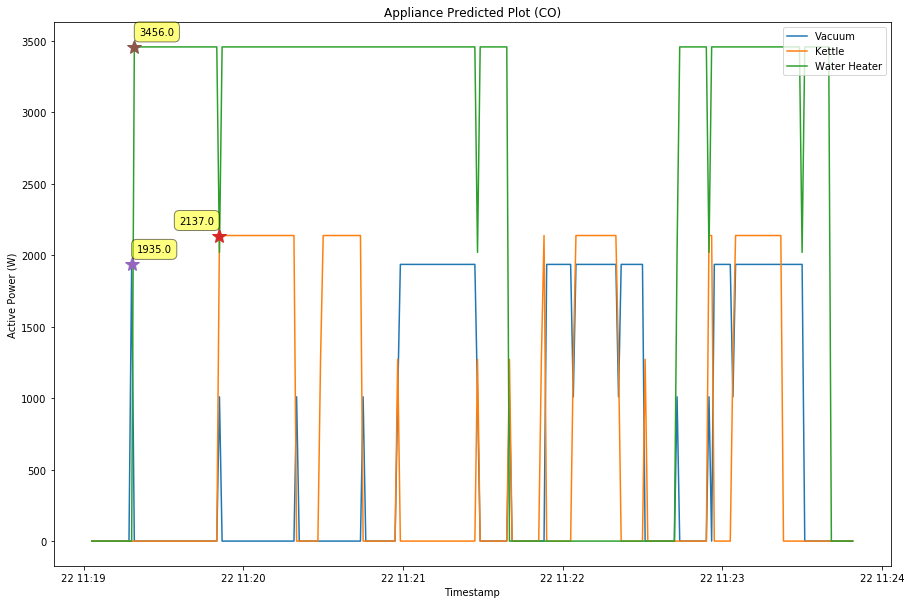

In [24]:
# Plot Predicted 
pred_vac = plt.plot(pred_overall.index, pred_overall['vacuum'], label = 'Vacuum')
pred_ke = plt.plot(pred_overall.index, pred_overall['kettle'], label = 'Kettle')
pred_wh = plt.plot(pred_overall.index, pred_overall['water heater'], label = 'Water Heater')
point1 = plt.plot(x_ke[0],ke_ss,marker="*",markersize=15)
point2 = plt.plot(x_vac[0],vac_ss,marker="*",markersize=15)
point3 = plt.plot(x_wh[0],wh_ss,marker="*",markersize=15)

plt.title("Appliance Predicted Plot (CO)")
plt.legend(loc=1)
plt.ylabel("Active Power (W)")
plt.xlabel("Timestamp")

# annotate kettle point
plt.annotate(
        ke_ss, 
        xy = (x_ke[0], ke_ss), xytext = (-5, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))
# annotate vacuum point
plt.annotate(
        vac_ss, 
        xy = (x_vac[0], vac_ss), xytext = (5, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))
# annotate water heater point
plt.annotate(
        wh_ss, 
        xy = (x_wh[0], wh_ss), xytext = (5, 10),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))

# Evaluation Metrics
- Evaluations metrics are used to evaluate how well the prediction is done by the trained model.
- The predicted disaggregated load(s) are evaluated using a few evaluation metrics for regression loss:
    1. **MSE**
    2. **RMSE**
    3. **MAE**
    4. **MAPE**
- Computed results shows the error/loss values of predicted to ground truth
    - The pair with the least loss is considered the closest prediction or the more accurate prediction to ground truth
    
1. **Mean Squared Error (MSE)**
    - The mean squared error (MSE) tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. It’s called the mean squared error as you’re finding the average of a set of errors. The lower the MSE, the better the prediction.
     
2. **Root Mean Squared Error (RMSE)**
    - Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit.
    
3. **Mean absolute error (MAE)**
    - Computes the mean of squares of errors between labeled data and predicted data. It calculates the absolute difference between the current output and the expected output divided by the number of output.
    
4. **Mean absolute percentage error (MAPE)**
    - is a measure of prediction accuracy of a forecasting method in statistics. It measures this accuracy as a percentage, and can be calculated as the average absolute percent error for each time period minus actual values divided by actual values.

In [25]:
def rmse(gt,pred):
    val = np.sqrt(mean_squared_error(gt,pred))
    return val

In [26]:
metrics = [mean_squared_error, rmse, mean_absolute_error, mean_absolute_percentage_error]
metrics_label = ['MSE','RMSE' ,'MAE', 'MAPE']

# Show metrics
for metric,lbl in zip(metrics,metrics_label):
    try:
        loss_function = metric
    except:
        print ("Loss function ",metric, " is not supported currently!")
        continue

    error = {}
    for app_name in gt_overall.columns:
        error[app_name] = loss_function(gt_overall[app_name],pred_overall[app_name])
    
    error = pd.Series(error)
    computed_metric = pd.DataFrame(error)
    print("............ " ,lbl," ..............")
    print(computed_metric.to_string(header=False))
    print("\n")

............  MSE  ..............
kettle         92035.000000
vacuum        101612.164062
water heater   63803.601562


............  RMSE  ..............
kettle        303.372711
vacuum        318.766632
water heater  252.593750


............  MAE  ..............
kettle        66.098991
vacuum        78.060837
water heater  58.169758


............  MAPE  ..............
kettle        1.667901e+17
vacuum        9.369684e+16
water heater  3.364659e-02




# Conclusion
- Train: kettle+vacuum+water_heater - 10 min data
- Test & disaggregate : kettle+vacuum+water_heater 4 mins data

1. Able to detect the appliances correctly
2. 3 combination is complicated to disaggregate properly

- Expected: Able to classify the appliances properly
- Result: Some errors in appliance activations